# Ensemble Long-term Analysis

Plots for the long-term performance temporal mean-Bias, zonal mean, spectra, zonal EOFs and PC autocorrelations, divergence, and return periods

In [1]:
import os, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
import yaml
import sys

from analysis.io_utils import load_params
from analysis.plot_config import params, contourLevels, colormap
from analysis.metrics import corr_truth_train_model
from analysis.visualization import ensembles_analysis, ensembles_analysis_return_period

In [2]:
### Set These Variables

plt_save_dir = '../results/figures/ensembles_analysis1/'
os.makedirs(plt_save_dir, exist_ok=True)

Lx, Ly = 2*np.pi, 2*np.pi
Nx, Ny = 256, 256

central_tendency = 'mean'  # mean median
error_bands = 'std'  # std 95ci 50ci

label = [r"Truth", r"Train", r"Emulator"]
color_marker = ['-k', '--r', '-.b']
color=['k', 'r', 'b']

In [3]:
# List all ensemble run_nuns
truth_analysis_dir = '../results/truth_Re5000_fkx0fky4_r0.1_b20/'
truth_run_names = ['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9', 'IC10']

emulator_analysis_dir = '../results/BASE/'
emulator_run_names = ['test1', 'test2', 'test3']

# For training data it's not a list of run names, but a single directory - error bands are not computed for training data
train_analysis_dir = '../results/BASE/'
train_run_name = ['test1']

data_type_arr = ['truth', 'train', 'emulate']
analysis_dir_arr = [truth_analysis_dir, train_analysis_dir, emulator_analysis_dir]
run_names_arr = [truth_run_names, train_run_name, emulator_run_names]

# Spectra

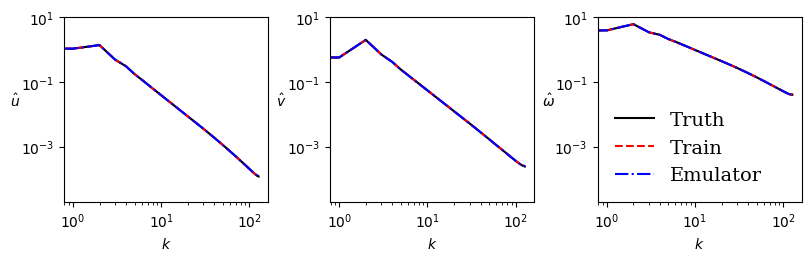

<Figure size 640x480 with 0 Axes>

In [4]:
################### Spectra ###################

fig, axes = plt.subplots(1,3,figsize=(8, 2.5), layout="compressed")  # Adjust figure size as needed
plt.rcParams.update(params)

for i, data_type in enumerate(data_type_arr):

    data = np.load(os.path.join(analysis_dir_arr[i], run_names_arr[i][0], 'analysis', data_type_arr[i]) + "/spectra.npz")
    wavenumbers = data['wavenumber_zonal_avg']

    U_spectra, U_spectra_lb, U_spectra_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'spectra_U_zonal_avg', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    V_spectra, V_spectra_lb, V_spectra_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'spectra_V_zonal_avg', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    Omega_spectra, Omega_spectra_lb, Omega_spectra_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'spectra_Omega_zonal_avg', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

    axes[0].loglog(wavenumbers[:-1], U_spectra[:-1], color_marker[i], label=label[i])

    axes[1].loglog(wavenumbers[:-1], V_spectra[:-1], color_marker[i], label=label[i])

    axes[2].loglog(wavenumbers[:-1], Omega_spectra[:-1], color_marker[i], label=label[i])

    if data_type_arr[i] in ['truth', 'emulate']:
        axes[0].fill_between(wavenumbers[:-1], U_spectra_lb[:-1], U_spectra_ub[:-1], color=color[i], alpha=0.2)
        axes[1].fill_between(wavenumbers[:-1], V_spectra_lb[:-1], V_spectra_ub[:-1], color=color[i], alpha=0.2)
        axes[2].fill_between(wavenumbers[:-1], Omega_spectra_lb[:-1], Omega_spectra_ub[:-1], color=color[i], alpha=0.2)


for ax in axes.flatten():
    ax.set_xlabel('$k$')
    ax.set_ylim([2e-5, 1e1])

axes[0].set_ylabel('$\hat{u}$', rotation=0)
axes[1].set_ylabel('$\hat{v}$', rotation=0)
axes[2].set_ylabel('$\hat{\omega}$', rotation=0)

axes[2].legend(frameon=False)
plt.show()
plt.savefig(plt_save_dir + '/spectra.png', dpi=600, bbox_inches='tight')

# Zonal Mean

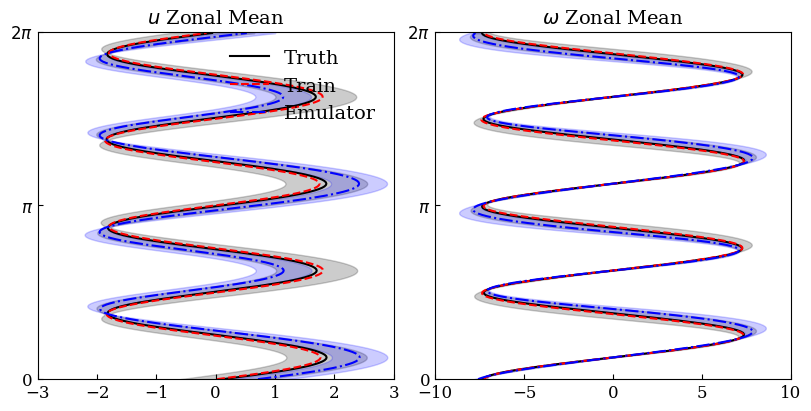

In [5]:
################### Zonal Mean ###################

fig, axes = plt.subplots(1,2,figsize=(8, 4), layout="compressed")  # Adjust figure size as needed
plt.rcParams.update(params)

dx = Lx/Nx
y = np.linspace(0,2*np.pi-dx,Nx)

for i, data_type in enumerate(data_type_arr):

    U_zonal_mean, U_zonal_mean_lb, U_zonal_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'U_zonal_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    Omega_zonal_mean, Omega_zonal_mean_lb, Omega_zonal_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'Omega_zonal_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

    axes[0].plot(U_zonal_mean, y, color_marker[i], label=label[i])
    axes[1].plot(Omega_zonal_mean, y, color_marker[i], label=label[i])

    if data_type_arr[i] in ['truth', 'emulate']:
        axes[0].fill_betweenx(y, U_zonal_mean_lb, U_zonal_mean_ub, color=color[i], alpha=0.2)
        axes[1].fill_betweenx(y, Omega_zonal_mean_lb, Omega_zonal_mean_ub, color=color[i], alpha=0.2)

axes[0].set_title(r'$u$ Zonal Mean')
axes[1].set_title(r'$\omega$ Zonal Mean')

for ax in axes.flatten():
    ax.set_yticks([0, np.pi, 2*np.pi])
    ax.set_yticklabels(['0', r'$\pi$', r'$2\pi$'])
    ax.set_ylim([0, 2*np.pi])


axes[0].set_xlim([-3, 3])
axes[1].set_xlim([-10, 10])

axes[0].legend(frameon=False)
fig.savefig(plt_save_dir + '/zonal_mean.png', dpi=600, bbox_inches='tight')



# Temporal Mean

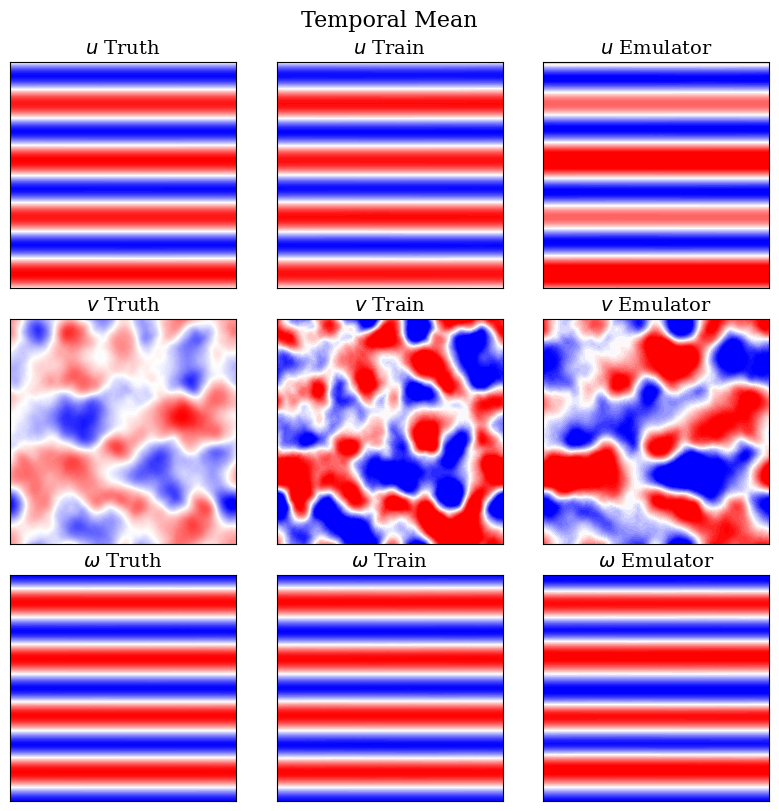

In [6]:
################### Sample Mean ###################

fig, axes = plt.subplots(3, 3, figsize=(8, 8), layout='constrained')
plt.rcParams.update(params)


for i, data_type in enumerate(data_type_arr):

    U_sample_mean, U_sample_mean_lb, U_sample_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'U_sample_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    V_sample_mean, V_sample_mean_lb, V_sample_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'V_sample_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    Omega_sample_mean, Omega_sample_mean_lb, Omega_sample_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'Omega_sample_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

    if i == 0:
        vmax_U = np.max(U_sample_mean)
        vmax_V = np.max(V_sample_mean)
        vmax_Omega = np.max(Omega_sample_mean)

    axes[0,i].contourf(U_sample_mean, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
    axes[1,i].contourf(V_sample_mean, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
    axes[2,i].contourf(Omega_sample_mean, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

    axes[0,i].set_title(rf"$u$ {label[i]}")
    axes[1,i].set_title(rf"$v$ {label[i]}")
    axes[2,i].set_title(rf"$\omega$ {label[i]}")

# Set aspect ratio to equal and remove labels for all axes
for ax in axes.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(r'Temporal Mean')

plt.savefig(plt_save_dir + '/temporal_mean.png', dpi=600, bbox_inches='tight')


# Bias: Temporal Mean

Sample Mean Correlations
Correlation: (Truth, Train), (Truth, Emulator), (Train, Emulator)
Corr U     : (np.float64(1.0), np.float64(0.93), np.float64(0.9))
Corr V     : (np.float64(0.45), np.float64(0.7), np.float64(0.65))
Corr Omega : (np.float64(1.0), np.float64(0.97), np.float64(0.96))


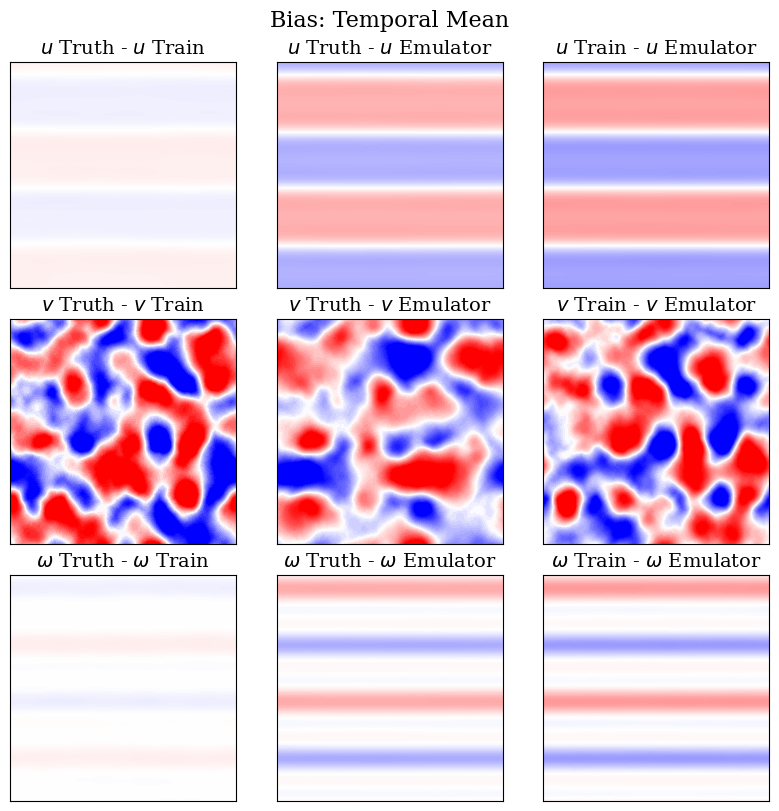

In [7]:
################### Sample Mean Diff ###################


for i, data_type in enumerate(data_type_arr):

    U_sample_mean, U_sample_mean_lb, U_sample_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'U_sample_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    V_sample_mean, V_sample_mean_lb, V_sample_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'V_sample_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    Omega_sample_mean, Omega_sample_mean_lb, Omega_sample_mean_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'Omega_sample_mean', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

    if data_type_arr[i] == 'truth':

        U_sample_mean_truth = U_sample_mean
        V_sample_mean_truth = V_sample_mean
        Omega_sample_mean_truth = Omega_sample_mean

    elif data_type_arr[i] == 'train':
        U_sample_mean_train = U_sample_mean
        V_sample_mean_train = V_sample_mean
        Omega_sample_mean_train = Omega_sample_mean
    elif data_type_arr[i] == 'emulate':

        U_sample_mean_emulator = U_sample_mean
        V_sample_mean_emulator = V_sample_mean
        Omega_sample_mean_emulator = Omega_sample_mean

    # if i == 0:
vmax_U = np.max(U_sample_mean_truth)
vmax_V = np.max(V_sample_mean_truth)
vmax_Omega = np.max(Omega_sample_mean_truth)

fig, axes = plt.subplots(3, 3, figsize=(8, 8), layout='constrained')
plt.rcParams.update(params)

axes[0,0].contourf(U_sample_mean_truth-U_sample_mean_train, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
axes[1,0].contourf(V_sample_mean_truth-V_sample_mean_train, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
axes[2,0].contourf(Omega_sample_mean_truth-Omega_sample_mean_train, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

axes[0,1].contourf(U_sample_mean_truth-U_sample_mean_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
axes[1,1].contourf(V_sample_mean_truth-V_sample_mean_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
axes[2,1].contourf(Omega_sample_mean_truth-Omega_sample_mean_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

axes[0,2].contourf(U_sample_mean_train-U_sample_mean_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
axes[1,2].contourf(V_sample_mean_train-V_sample_mean_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
axes[2,2].contourf(Omega_sample_mean_train-Omega_sample_mean_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)


fig.suptitle(r'Bias: Temporal Mean')
axes[0,0].set_title(r'$u$ Truth - $u$ Train')
axes[0,1].set_title(r'$u$ Truth - $u$ Emulator')
axes[0,2].set_title(r'$u$ Train - $u$ Emulator')

axes[1,0].set_title(r'$v$ Truth - $v$ Train')
axes[1,1].set_title(r'$v$ Truth - $v$ Emulator')
axes[1,2].set_title(r'$v$ Train - $v$ Emulator')

axes[2,0].set_title(r'$\omega$ Truth - $\omega$ Train')
axes[2,1].set_title(r'$\omega$ Truth - $\omega$ Emulator')
axes[2,2].set_title(r'$\omega$ Train - $\omega$ Emulator')

for ax in axes.flatten():
    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(plt_save_dir + '/temporal_mean_diff.png', dpi=600, bbox_inches='tight')

print('Sample Mean Correlations')
print('Correlation: (Truth, Train), (Truth, Emulator), (Train, Emulator)')
print('Corr U     :', corr_truth_train_model(U_sample_mean_truth, U_sample_mean_train, U_sample_mean_emulator))
print('Corr V     :', corr_truth_train_model(V_sample_mean_truth, V_sample_mean_train, V_sample_mean_emulator))
print('Corr Omega :', corr_truth_train_model(Omega_sample_mean_truth, Omega_sample_mean_train, Omega_sample_mean_emulator))

## EOF 
**Note**: Signs of EOFs have been aligned - although there still may be different and can produce incorrent means.

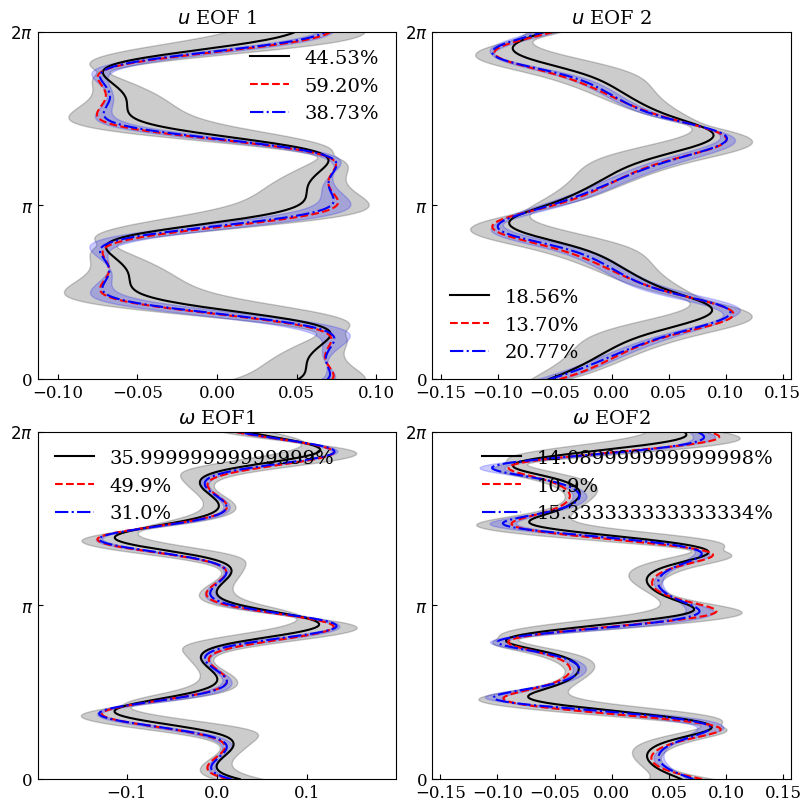

In [8]:
################### EOF ###################

fig, axes = plt.subplots(2,2,figsize=(8, 8), layout="compressed")  # Adjust figure size as needed
plt.rcParams.update(params)


for i, data_type in enumerate(data_type_arr):

    EOF_U, EOF_U_lb, EOF_U_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'U_eofs', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    EOF_Omega, EOF_Omega_lb, EOF_Omega_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'Omega_eofs', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

    exp_var_U, exp_var_U_lb, exp_var_U_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'U_expvar', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    exp_var_Omega, exp_var_Omega_lb, exp_var_Omega_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'Omega_expvar', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

    y = np.linspace(0, Lx, Ny)

    for count in range(2):
        axes[0,count].plot(EOF_U[:,count], y, color_marker[i], label=f'{exp_var_U[count]:.2f}%')
        axes[1,count].plot(EOF_Omega[:,count], y, color_marker[i], label=f'{exp_var_Omega[count]}%')

    if data_type_arr[i] in ['truth', 'emulate']:
        for count in range(2):
            axes[0,count].fill_betweenx(y, EOF_U_lb[:,count], EOF_U_ub[:,count], color=color[i], alpha=0.2)
            axes[1,count].fill_betweenx(y, EOF_Omega_lb[:,count], EOF_Omega_ub[:,count], color=color[i], alpha=0.2)

for ax in axes.flatten():
    ax.set_yticks([0, np.pi, 2*np.pi])
    ax.set_yticklabels(['0', r'$\pi$', r'$2\pi$'])
    ax.set_ylim([0, 2*np.pi])


for count in range(2):
    axes[0,count].set_title(rf'$u$ EOF {count+1}')
    EOF_max = np.max(np.abs([EOF_U[:,count]]))
    axes[0,count].set_xlim([-1.5*EOF_max, 1.5*EOF_max])
    axes[0,count].legend(frameon=False)

    axes[1,count].set_title(rf'$\omega$ EOF{count+1}')
    EOF_max = np.max(np.abs([EOF_Omega[:,count]]))
    axes[1,count].set_xlim([-1.5*EOF_max, 1.5*EOF_max])
    axes[1,count].legend(frameon=False)

plt.show()
fig.savefig(plt_save_dir + '/zonal_EOFs.png', dpi=600, bbox_inches='tight')


## PC Auto-Correlation

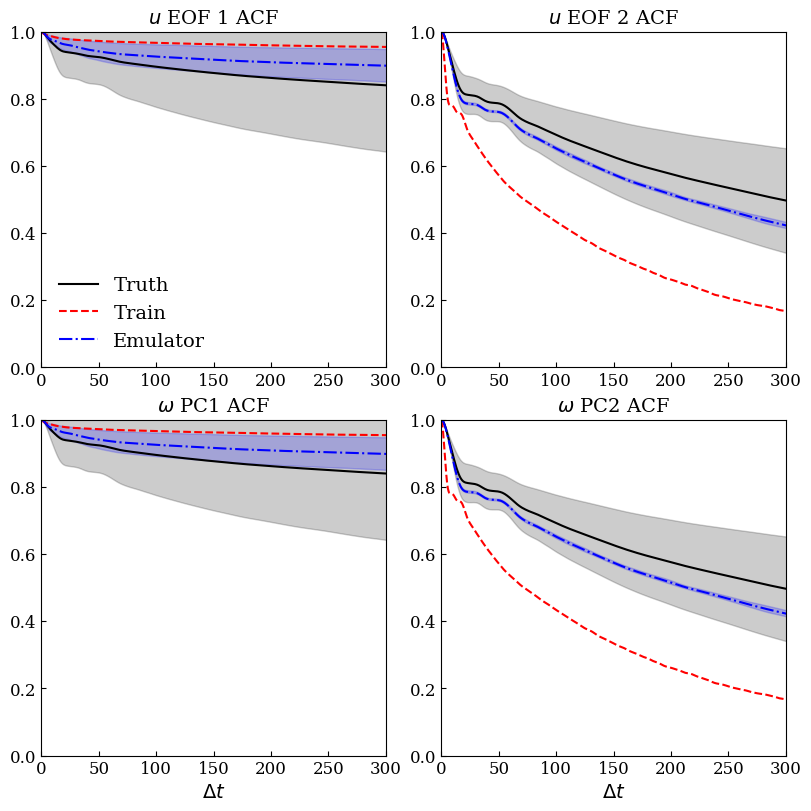

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), layout='constrained')
plt.rcParams.update(params)

for i, data_type in enumerate(data_type_arr):

    acf_U, acf_U_lb, acf_U_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'U_pc_acf', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
    acf_Omega, acf_Omega_lb, acf_Omega_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'Omega_pc_acf', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)


    for count in range(2):

        # Training data and emulation data are saved at different time steps
        if data_type in ['emulate', 'truth']:
            time = np.linspace(0, acf_U.shape[0], acf_U.shape[0])
        else:
            time = np.linspace(0, acf_U.shape[0]/3, acf_U.shape[0])

    for count in range(2):
        axes[0,count].plot(time, acf_U[:,count], color_marker[i], label=label[i])
        axes[1,count].plot(time, acf_Omega[:,count], color_marker[i], label=label[i])

        if data_type_arr[i] in ['truth', 'emulate']:
            axes[0,count].fill_between(time, acf_U_lb[:,count], acf_U_ub[:,count], color=color[i], alpha=0.2)
            axes[1,count].fill_between(time, acf_Omega_lb[:,count], acf_Omega_ub[:,count], color=color[i], alpha=0.2)
        
        axes[0,count].set_title(rf'$u$ EOF {count+1} ACF')
        axes[1,count].set_title(rf'$\omega$ PC{count+1} ACF')

        axes[1,count].set_xlabel('$\Delta t$')


for ax in axes.flatten():
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 300])

axes[0,0].legend(frameon=False)
#axes[1,0].legend(frameon=False)

    # axes[0,0].legend()
    # axes[1,0].legend()

plt.savefig(plt_save_dir + '/zonal_pc_acfs.png', dpi=600, bbox_inches='tight')


# Divergence

/ocean/projects/atm170004p/jakhar/.envs/fourks/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/ocean/projects/atm170004p/jakhar/.envs/fourks/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


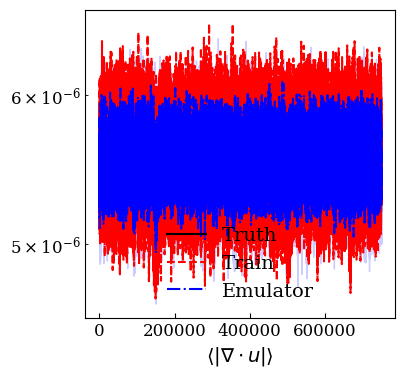

In [10]:
fig, axes = plt.subplots(1, figsize=(4, 4))
plt.rcParams.update(params)

for i, data_type in enumerate(data_type_arr):

    div, div_lb, div_ub = ensembles_analysis(
        analysis_dir_arr[i], run_names_arr[i], 'div', data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

    axes.semilogy(div, color_marker[i], label=label[i])
    if data_type_arr[i] in ['truth', 'emulate']:
        axes.fill_between(np.arange(len(div)), div_lb, div_ub, color=color[i], alpha=0.2)

axes.set_xlabel(r'$ \langle |\nabla \cdot u |\rangle$', rotation=0)
axes.legend(frameon=False)

# plt.savefig(plt_save_dir + '/div.png', dpi=600, bbox_inches='tight')


## Return Period

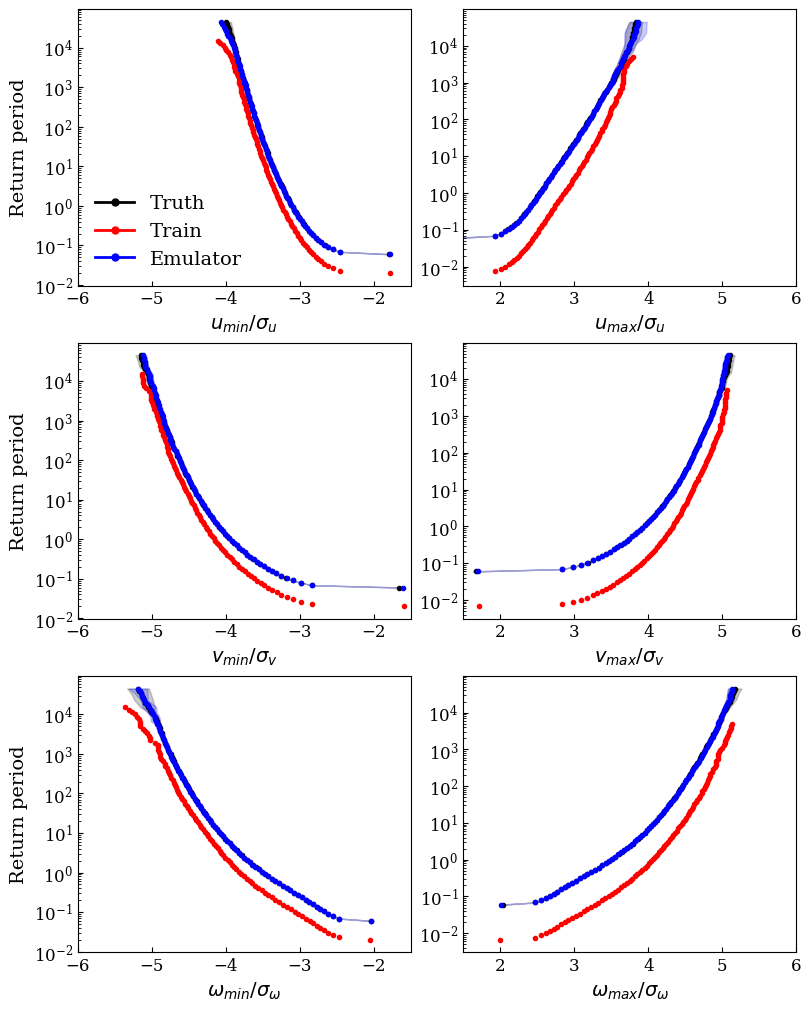

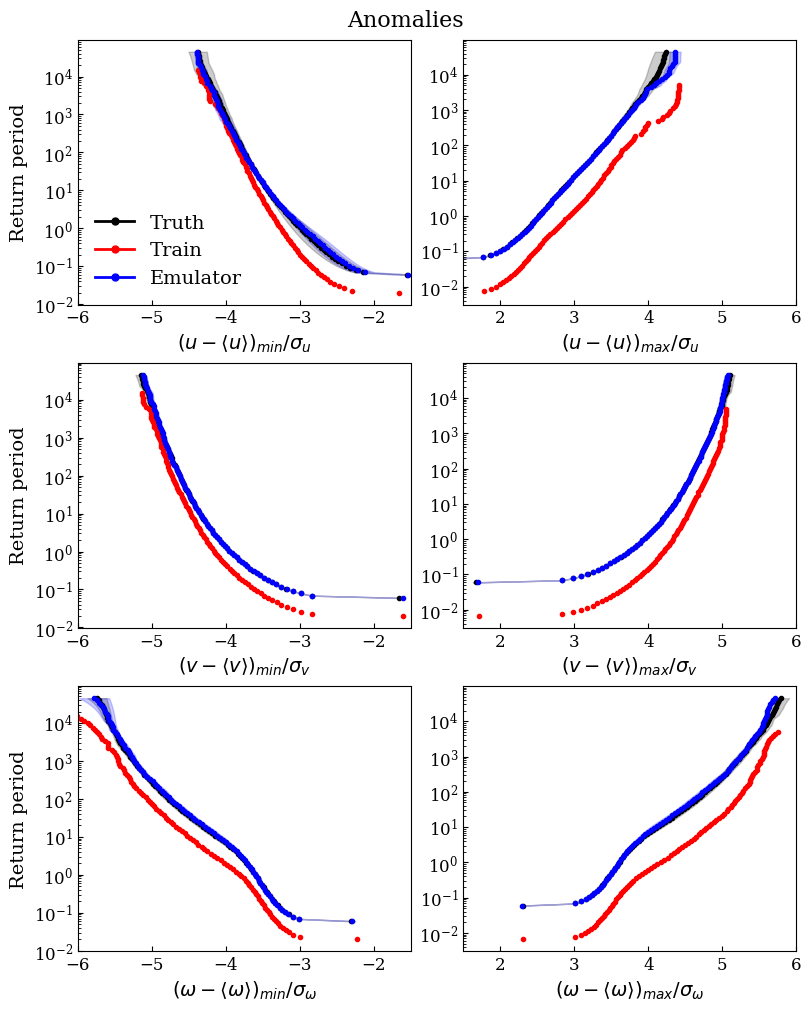

In [12]:

dt_data = 0.06
markersize = 3
U_std = 2.34
V_std = 1.88
Omega_std = 10.41
bins_num = 100



for anom in [False, True]:

    fig, axes = plt.subplots(3, 2, figsize=(8, 10), layout='constrained')
    plt.rcParams.update(params)
    
    for i, data_type in enumerate(data_type_arr):

        if data_type_arr[i] == 'train':
            dt = dt_data / 3
        else:
            dt = dt_data

        U_min_return_period, U_min_data_amplitude, U_min_data_amplitude_lb, U_min_data_amplitude_ub, = ensembles_analysis_return_period(
            analysis_dir_arr[i], run_names_arr[i], 'U_min_arr', anom, std=U_std, dt=dt_data, bins_num=bins_num, data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
        U_max_return_period, U_max_data_amplitude, U_max_data_amplitude_lb, U_max_data_amplitude_ub, = ensembles_analysis_return_period(
            analysis_dir_arr[i], run_names_arr[i], 'U_max_arr', anom, std=U_std, dt=dt, bins_num=bins_num, data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
        V_min_return_period, V_min_data_amplitude, V_min_data_amplitude_lb, V_min_data_amplitude_ub, = ensembles_analysis_return_period(
            analysis_dir_arr[i], run_names_arr[i], 'V_min_arr', anom, std=V_std, dt=dt_data, bins_num=bins_num, data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
        V_max_return_period, V_max_data_amplitude, V_max_data_amplitude_lb, V_max_data_amplitude_ub, = ensembles_analysis_return_period(
            analysis_dir_arr[i], run_names_arr[i], 'V_max_arr', anom, std=V_std, dt=dt, bins_num=bins_num, data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
        Omega_min_return_period, Omega_min_data_amplitude, Omega_min_data_amplitude_lb, Omega_min_data_amplitude_ub, = ensembles_analysis_return_period(
            analysis_dir_arr[i], run_names_arr[i], 'Omega_min_arr', anom, std=Omega_std, dt=dt_data, bins_num=bins_num, data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)
        Omega_max_return_period, Omega_max_data_amplitude, Omega_max_data_amplitude_lb, Omega_max_data_amplitude_ub, = ensembles_analysis_return_period(
            analysis_dir_arr[i], run_names_arr[i], 'Omega_max_arr', anom, std=Omega_std, dt=dt, bins_num=bins_num, data_type=data_type_arr[i], central_tendency=central_tendency, error_bands=error_bands)

        axes[0,0].semilogy(U_min_data_amplitude, U_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
        axes[0,1].semilogy(U_max_data_amplitude, U_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
        axes[1,0].semilogy(V_min_data_amplitude, V_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
        axes[1,1].semilogy(V_max_data_amplitude, V_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
        axes[2,0].semilogy(Omega_min_data_amplitude, Omega_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
        axes[2,1].semilogy(Omega_max_data_amplitude, Omega_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
        

        if data_type in ['truth', 'emulate']:
            axes[0,0].fill_betweenx(U_min_return_period, U_min_data_amplitude_lb, U_min_data_amplitude_ub, color=color[i], alpha=0.2)
            axes[0,1].fill_betweenx(U_max_return_period, U_max_data_amplitude_lb, U_max_data_amplitude_ub, color=color[i], alpha=0.2)
            axes[1,0].fill_betweenx(V_min_return_period, V_min_data_amplitude_lb, V_min_data_amplitude_ub, color=color[i], alpha=0.2)
            axes[1,1].fill_betweenx(V_max_return_period, V_max_data_amplitude_lb, V_max_data_amplitude_ub, color=color[i], alpha=0.2)
            axes[2,0].fill_betweenx(Omega_min_return_period, Omega_min_data_amplitude_lb, Omega_min_data_amplitude_ub, color=color[i], alpha=0.2)
            axes[2,1].fill_betweenx(Omega_max_return_period, Omega_max_data_amplitude_lb, Omega_max_data_amplitude_ub, color=color[i], alpha=0.2)

    if anom:
        axes[0,0].set_xlabel(r'$\left(u-\langle u\rangle\right)_{min}/\sigma_u$')
        axes[0,1].set_xlabel(r'$\left(u-\langle u\rangle\right)_{max}/\sigma_u$')
        axes[1,0].set_xlabel(r'$\left(v-\langle v\rangle\right)_{min}/\sigma_v$')
        axes[1,1].set_xlabel(r'$\left(v-\langle v\rangle\right)_{max}/\sigma_v$')
        axes[2,0].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{min}/\sigma_{\omega}$')
        axes[2,1].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{max}/\sigma_{\omega}$')

    else:
        axes[0,0].set_xlabel(r'$u_{min}/\sigma_u$')
        axes[0,1].set_xlabel(r'$u_{max}/\sigma_u$')
        axes[1,0].set_xlabel(r'$v_{min}/\sigma_v$')
        axes[1,1].set_xlabel(r'$v_{max}/\sigma_v$')
        axes[2,0].set_xlabel(r'$\omega_{min}/\sigma_{\omega}$')
        axes[2,1].set_xlabel(r'$\omega_{max}/\sigma_{\omega}$')

    axes[0,0].set_ylabel('Return period')
    axes[1,0].set_ylabel('Return period')
    axes[2,0].set_ylabel('Return period')

    axes[0,0].set_xlim([-6, -1.5])
    axes[0,1].set_xlim([1.5, 6])
    axes[1,0].set_xlim([-6, -1.5])
    axes[1,1].set_xlim([1.5, 6])
    axes[2,0].set_xlim([-6, -1.5])
    axes[2,1].set_xlim([1.5, 6])

    # Use custom legend handles with dashed lines instead of marker symbols
    custom_lines = [
        Line2D([0], [0], color=color[0], marker='o', lw=2, label=label[0]),
        Line2D([0], [0], color=color[1], marker='o', lw=2, label=label[1]),
        Line2D([0], [0], color=color[2], marker='o', lw=2, label=label[2])
    ]
    axes[0,0].legend(handles=custom_lines, frameon=False)

    # Save figure with different filenames for anom True/False
    if anom:
        plt.suptitle('Anomalies')
        plt.savefig(plt_save_dir + '/return_period_anom.png', dpi=600, bbox_inches='tight')
    else:
        plt.savefig(plt_save_dir + '/return_period.png', dpi=600, bbox_inches='tight')
